In [19]:
%matplotlib inline
import os
import sys
os.environ["THEANO_FLAGS"] = "device=cpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold
from lasagnekit.misc.plot_weights import tile_raster_images
import matplotlib.pyplot as plt
import numpy as np

In [3]:
v = check(what="notebook", 
          #filename="..//model.pkl", 
          filename="../training/reproduce_bengio_denoising/minibatch/model.pkl",
          dataset="digits")

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...
/home/mcherti/work/code/notmine/Lasagne/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	determnistic (perhaps you meant deterministic)
  % "\n\t".join(suggestions))


{'seed': 2}


In [4]:
capsule, data, layers, w, h, c = v
print(w, h, c)
print(layers.keys())

(28, 28, 1)
['input', 'hid', 'hid_sparse', 'pre_output', 'output']


In [8]:
img = tile_raster_images(data.X[0:100], (28, 28), (10, 10))

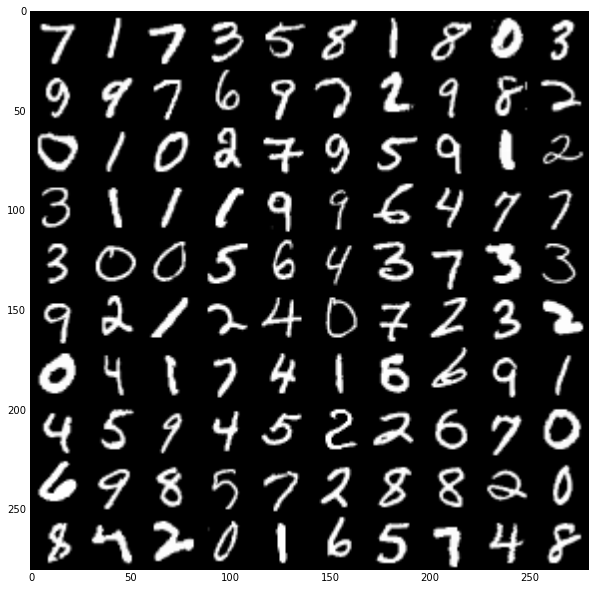

In [12]:
img = tile_raster_images(data.X[0:100], (28, 28), (10, 10))
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

(array([   2.,   12.,   71.,  167.,  244.,  258.,  153.,   69.,   20.,    4.]),
 array([ 265.86541748,  273.39502563,  280.92463379,  288.45424194,
         295.9838501 ,  303.51345825,  311.04306641,  318.57267456,
         326.10228271,  333.63189087,  341.16149902]),
 <a list of 10 Patch objects>)

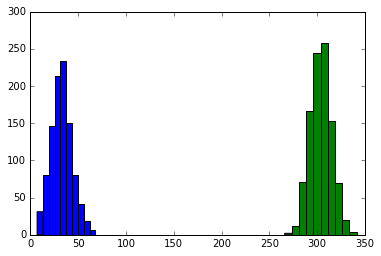

In [54]:
X = capsule.preprocess(data.train.X[0:1000])
R = np.random.uniform(size=(1000, c, w, h)).astype(np.float32) > 0.5
plt.hist(((capsule.reconstruct(X) - X)**2).sum(axis=(1, 2, 3)))
plt.hist(((capsule.reconstruct(R) - R)**2).sum(axis=(1, 2, 3)))

In [59]:
X = T.tensor4()
y = T.ivector()

In [221]:
Xnew_data = capsule.preprocess(data.train.X[0:100])
Xold_data = capsule.preprocess(data.train.X[0:100])
Xnew_data = theano.shared(Xnew_data.astype(np.float32))
print(Xnew_data)

<TensorType(float32, 4D)>


In [222]:
Xfull = np.concatenate((Xnew_data.get_value(), Xold_data))
yfull = np.array([1] * len(Xnew_data.get_value()) + [0] * len(Xold_data)).astype(np.int32)
print(Xfull.shape, yfull.shape)

((200, 1, 28, 28), (200,))


In [223]:
from lasagne.layers import DenseLayer, InputLayer, ReshapeLayer
from lasagne import nonlinearities
from lasagnekit.easy import iterate_minibatches
from lasagne import objectives, layers, updates

In [224]:
#Disc
D_input_layer = InputLayer((None, c, w, h))
hid = DenseLayer(D_input_layer, 
                 num_units=1000, 
                 #W=capsule.layers['hid'].W.get_value(), b=capsule.layers['hid'].b.get_value(),
                 nonlinearity=nonlinearities.sigmoid)
D_out = DenseLayer(hid, 2, nonlinearity=nonlinearities.softmax)

In [225]:
Xnew_data_s = T.nnet.sigmoid(Xnew_data)
rec_score = ((layers.get_output(capsule.layers['output'], Xnew_data_s) - Xnew_data_s)**2).mean(axis=(1, 2, 3))

In [226]:
#Gen
z = 100
G_input_layer = InputLayer((None, z))
hid = DenseLayer(G_input_layer, 
                 num_units=1000, 
                 nonlinearity=nonlinearities.rectify)
G_out = DenseLayer(hid, (c*w*h), nonlinearity=nonlinearities.sigmoid)
G_out = ReshapeLayer(G_out, ([0], c, w, h))

In [227]:
pred = layers.get_output(D_out, X)
loss = objectives.categorical_crossentropy(pred, y)
pred_new = layers.get_output(D_out, Xnew_data_s)
loss += objectives.categorical_crossentropy(pred_new, y)
loss += rec_score
loss = loss.mean()

In [228]:
params = lasagne.layers.get_all_params(D_out, trainable=True) + [Xnew_data] 

In [229]:
updates = lasagne.updates.adam(loss, params, learning_rate=0.01)

In [230]:
train_fn = theano.function([X, y], loss, updates=updates)
predict_fn = theano.function([X], pred)

In [231]:
for epoch in range(1000):
    for sl in iterate_minibatches(Xfull.shape[0], 100):
        l = train_fn(Xfull[sl], yfull[sl])
    if epoch % 100 == 0:
        print(l)
        print((predict_fn(Xfull).argmax(axis=1)==yfull).mean())

53.2278022766
0.5
1.53630292416
0.5
1.43628895283
0.5
1.40140259266
0.5
1.39363002777
0.5
1.39171648026
0.5
1.39075195789
0.5
1.39003193378
0.5
1.38971149921
0.5
1.38921117783
0.5


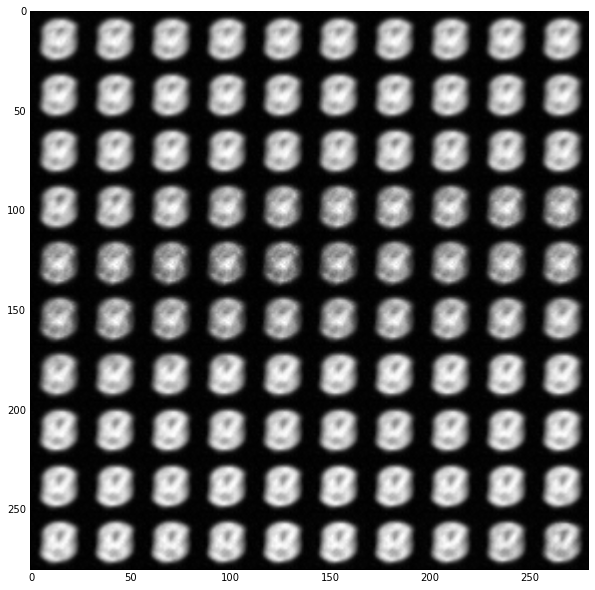

In [232]:
def sig(x):
    return 1./(1.+np.exp(-x))
img = tile_raster_images(sig(Xnew_data.get_value()[:, 0]), (28, 28), (10, 10))
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')